#📌 Extracción

In [4]:
import requests
import pandas as pd
from pandas import json_normalize

URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

resp = requests.get(URL, timeout=60)
resp.raise_for_status()
data = resp.json()

# Vista rápida del JSON como lista de dicts
df = pd.DataFrame(data)
print(df.head())

# JSON anidado → normalizar (aplanar con punto como separador)
df_normalizado = json_normalize(data, sep=".")
print("\n--- info (crudo normalizado) ---")
df_normalizado.info()


# === Vista controlada de las 21 columnas (sin alterar df ni df_normalizado) ===
COLUMNAS_21 = [
    "customerID","Churn","customer.gender","customer.SeniorCitizen","customer.Partner",
    "customer.Dependents","customer.tenure","phone.PhoneService","phone.MultipleLines",
    "internet.InternetService","internet.OnlineSecurity","internet.OnlineBackup",
    "internet.DeviceProtection","internet.TechSupport","internet.StreamingTV",
    "internet.StreamingMovies","account.Contract","account.PaperlessBilling",
    "account.PaymentMethod","account.Charges.Monthly","account.Charges.Total"
]

# Verificación rápida de cobertura de columnas
faltantes = [c for c in COLUMNAS_21 if c not in df_normalizado.columns]
if faltantes:
    print("⚠️ Faltan columnas en el normalizado:", faltantes)
else:
    print("✅ Las 21 columnas están presentes en el DataFrame normalizado.")

# Crear una VISTA (copia) solo para mostrar las 21 columnas
df_21view = df_normalizado[COLUMNAS_21].copy()

print("\n--- Columnas (21) ---")
print(df_21view.columns.tolist())

print("\n--- Dimensiones del DataFrame ---")
print(df_21view.shape)

# Mostrar en bloques de 5 filas
print("\n--- Primeras 25 filas en 5 bloques de 5 ---")
filas_por_bloque = 5
num_bloques = 5
for i in range(num_bloques):
    inicio = i * filas_por_bloque
    fin = inicio + filas_por_bloque
    print(f"\n📄 Bloque {i+1} (filas {inicio} a {fin-1}):")
    print(df_21view.iloc[inicio:fin].to_string(index=False))

print("\n--- Información general (21 columnas) ---")
df_21view.info()


   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

#🔧 Transformación

In [ ]:
import numpy as np

# 21 columnas esperadas (en el mismo orden que tu df.info de referencia)
COLUMNAS_21 = [
    "customerID","Churn","customer.gender","customer.SeniorCitizen","customer.Partner",
    "customer.Dependents","customer.tenure","phone.PhoneService","phone.MultipleLines",
    "internet.InternetService","internet.OnlineSecurity","internet.OnlineBackup",
    "internet.DeviceProtection","internet.TechSupport","internet.StreamingTV",
    "internet.StreamingMovies","account.Contract","account.PaperlessBilling",
    "account.PaymentMethod","account.Charges.Monthly","account.Charges.Total"
]

# Recorte/orden exacto de columnas (no sumar ni quitar)
df_21 = df_normalizado[COLUMNAS_21].copy()

# --- Normalización de textos: solo en columnas object
for col in df_21.select_dtypes(include="object").columns:
    df_21[col] = df_21[col].astype(str).str.strip()

# --- Strings vacíos → NaN (solo object)
obj_cols = df_21.select_dtypes(include="object").columns
df_21[obj_cols] = df_21[obj_cols].replace({"": pd.NA})

# --- Tipos de datos (ajuste profesional)
#   - customer.SeniorCitizen, customer.tenure: enteros
#   - account.Charges.Monthly: float
#   - account.Charges.Total: float (viene como object, incluye números como strings y vacíos)
df_21["customer.SeniorCitizen"] = pd.to_numeric(df_21["customer.SeniorCitizen"], errors="coerce").astype("Int64")
df_21["customer.tenure"]        = pd.to_numeric(df_21["customer.tenure"], errors="coerce").astype("Int64")
df_21["account.Charges.Monthly"] = pd.to_numeric(df_21["account.Charges.Monthly"], errors="coerce").astype(float)
df_21["account.Charges.Total"]   = pd.to_numeric(df_21["account.Charges.Total"], errors="coerce").astype(float)

print("\n--- info (tras tipado y normalización) ---")
df_21.info()

# --- Chequeos de coherencia básica de servicios (sin crear columnas nuevas)
# Si NO hay InternetService → add-ons no deberían estar activos (se normaliza a "No internet service")
sin_internet = df_21["internet.InternetService"].astype(str).str.lower().isin(["no", "no internet service"])
addons = [
    "internet.OnlineSecurity","internet.OnlineBackup","internet.DeviceProtection",
    "internet.TechSupport","internet.StreamingTV","internet.StreamingMovies"
]
for col in addons:
    # Donde no hay internet y el addon es NaN o "Yes", anotamos "No internet service"
    mask_fix = sin_internet & df_21[col].isna()
    df_21.loc[mask_fix, col] = "No internet service"
    # Limpieza leve de variantes
    df_21[col] = df_21[col].replace({"No Internet Service":"No internet service"})

# Si NO hay PhoneService → MultipleLines no debería ser "Yes" (se armoniza a "No phone service" si está vacío)
no_phone = df_21["phone.PhoneService"].astype(str).str.lower().isin(["no", "no phone service"])
df_21.loc[no_phone & df_21["phone.MultipleLines"].isna(), "phone.MultipleLines"] = "No phone service"
df_21["phone.MultipleLines"] = df_21["phone.MultipleLines"].replace({"No Phone Service":"No phone service"})




--- info (tras tipado y normalización) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   Int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   Int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  inte

#📊 Carga y análisis


Guardado: data/processed/telecomx_21cols.parquet & .csv

--- Valores únicos por columna ---
Valores únicos en la columna 'customerID': 7267
Valores únicos en la columna 'Churn': 2
['No' 'Yes']
--------------------------------------------------
Valores únicos en la columna 'customer.gender': 2
['Female' 'Male']
--------------------------------------------------
Valores únicos en la columna 'customer.SeniorCitizen': 2
<IntegerArray>
[0, 1]
Length: 2, dtype: Int64
--------------------------------------------------
Valores únicos en la columna 'customer.Partner': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna 'customer.Dependents': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna 'customer.tenure': 73
Valores únicos en la columna 'phone.PhoneService': 2
['Yes' 'No']
--------------------------------------------------
Valores únicos en la columna 'phone.MultipleLines': 3
['No' 'Yes' 'No phone servi

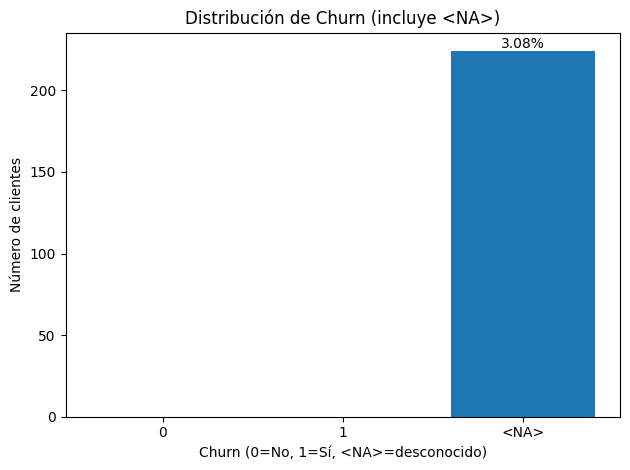

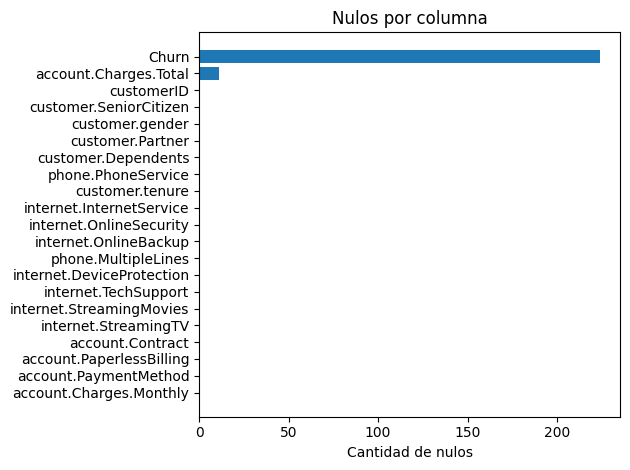

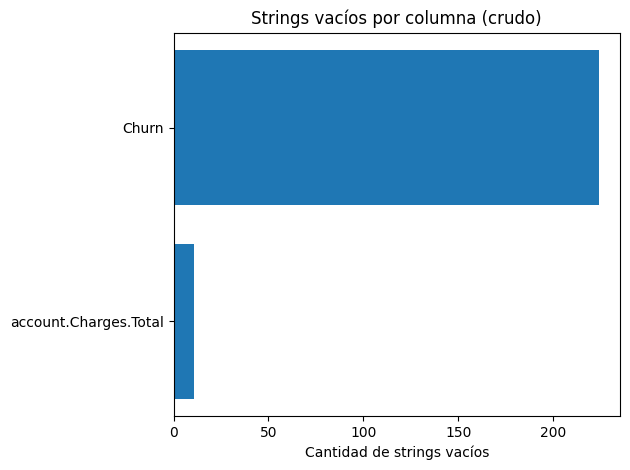

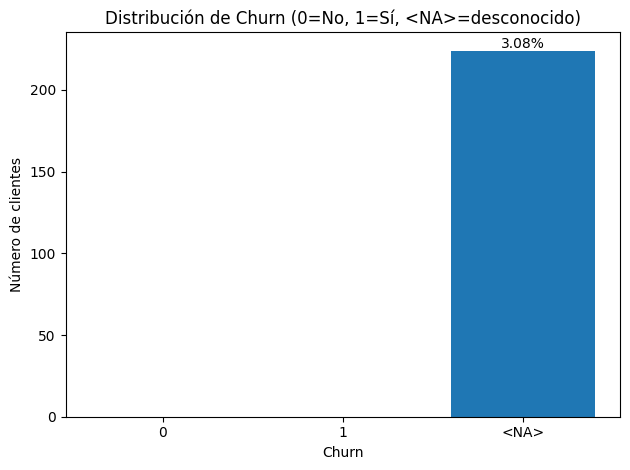

/tmp/ipython-input-2857538633.py:139: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_num = churn_num.fillna(m)


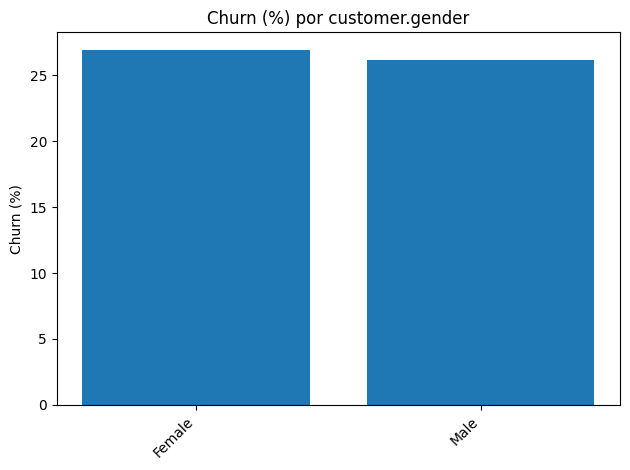

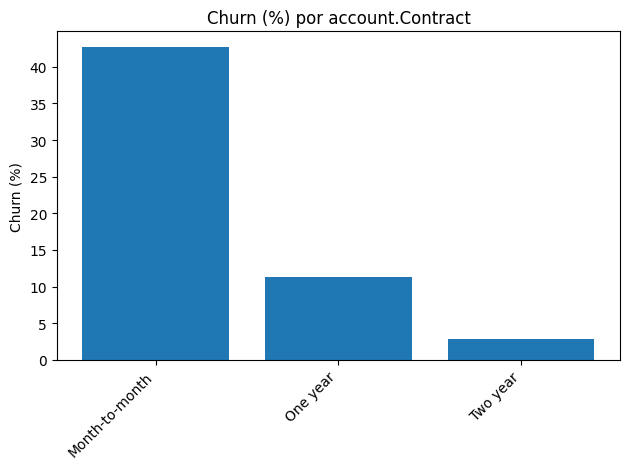

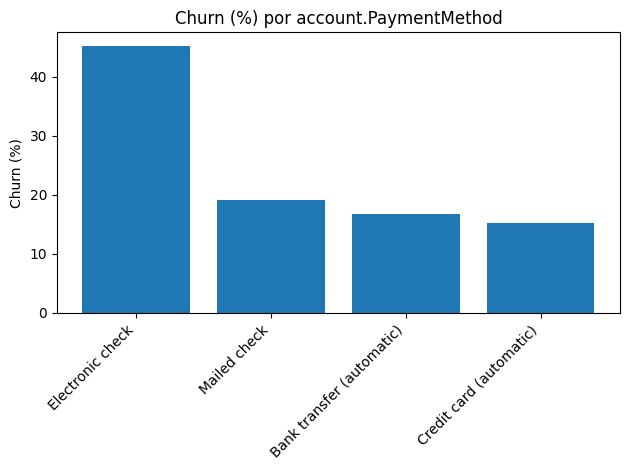

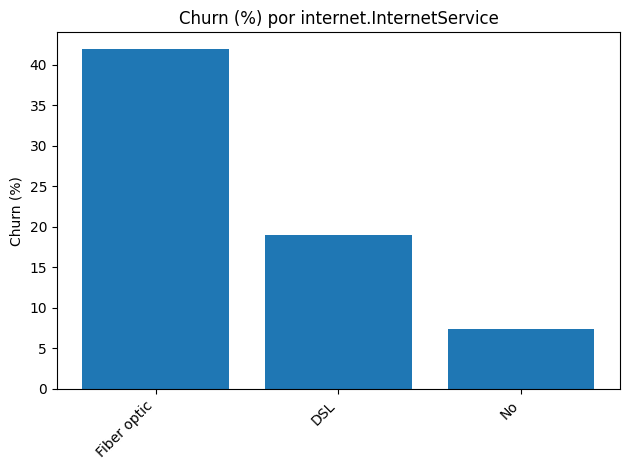

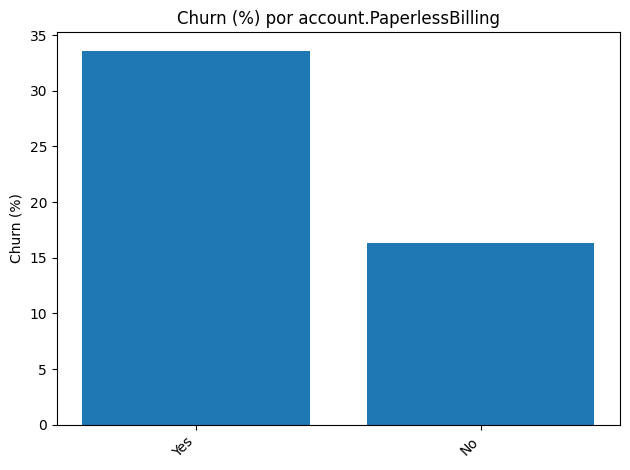

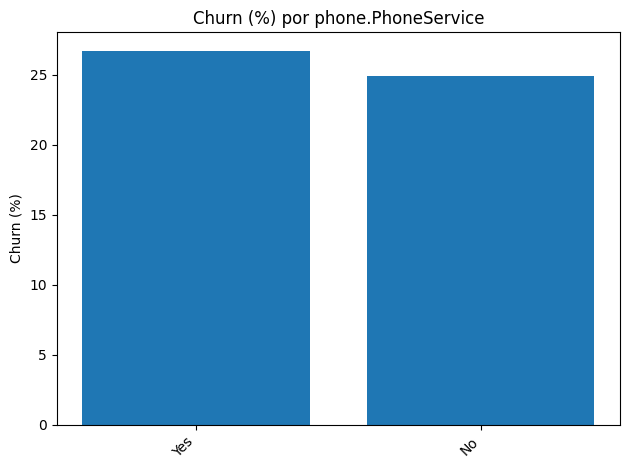

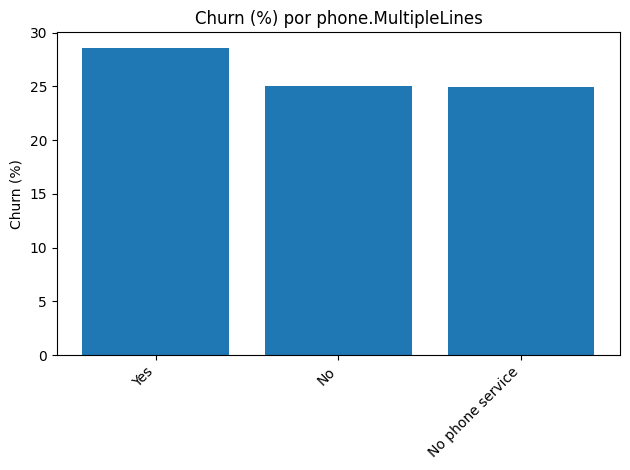

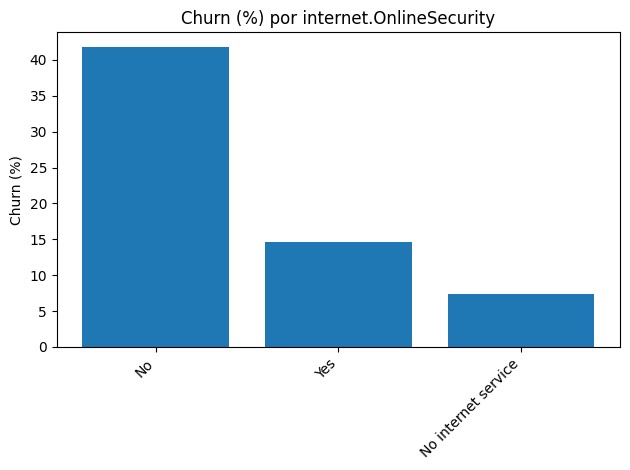

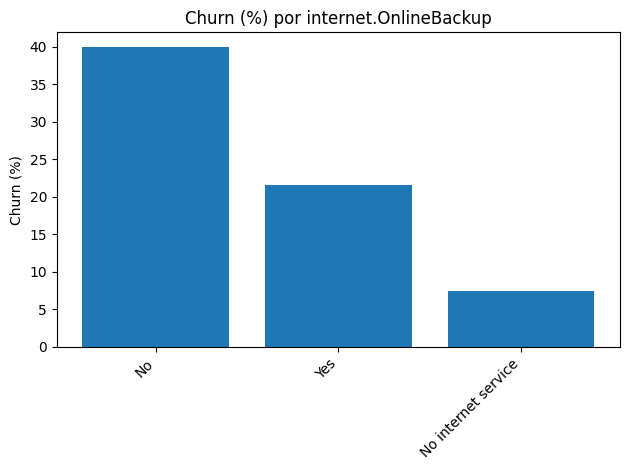

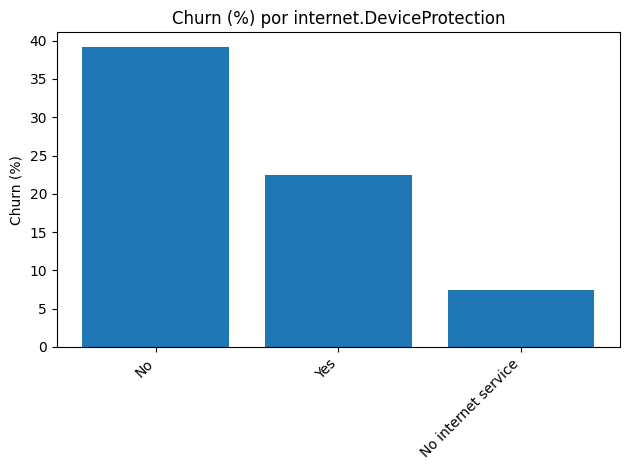

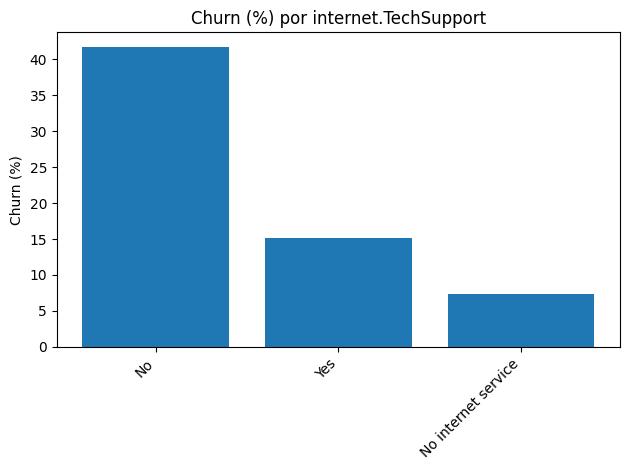

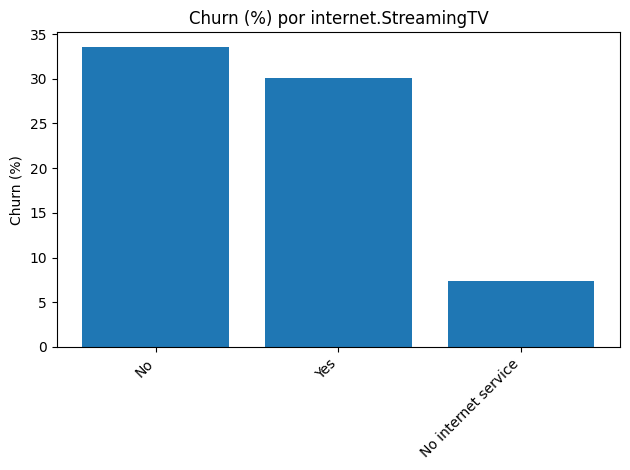

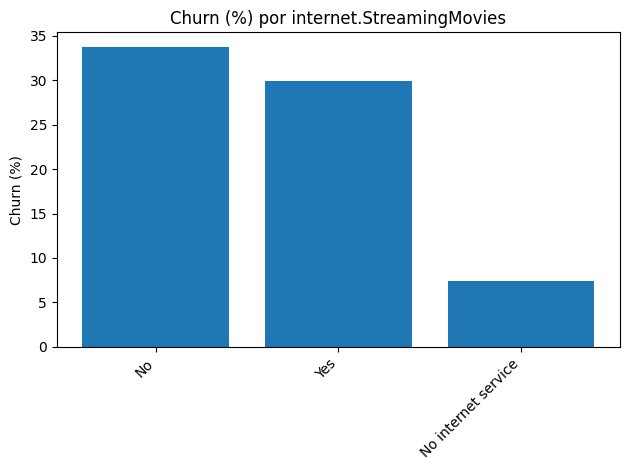

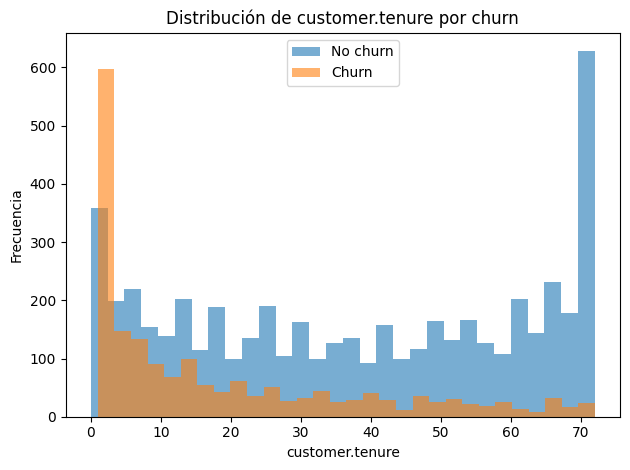

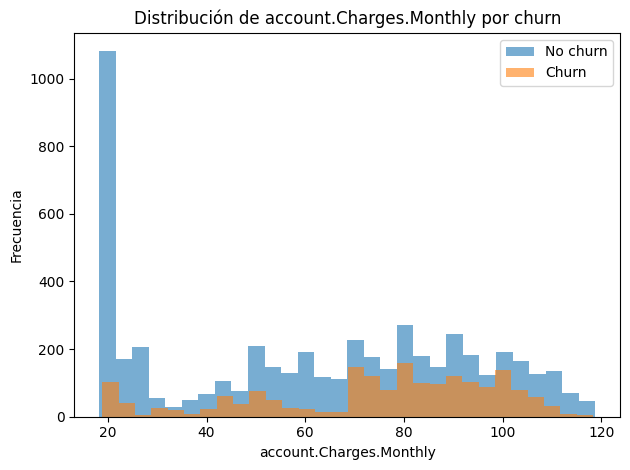

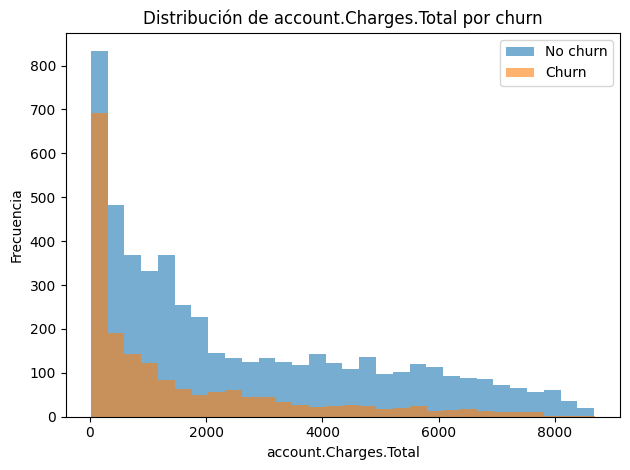

/tmp/ipython-input-2857538633.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos, labels=["No churn","Churn"], showfliers=True)


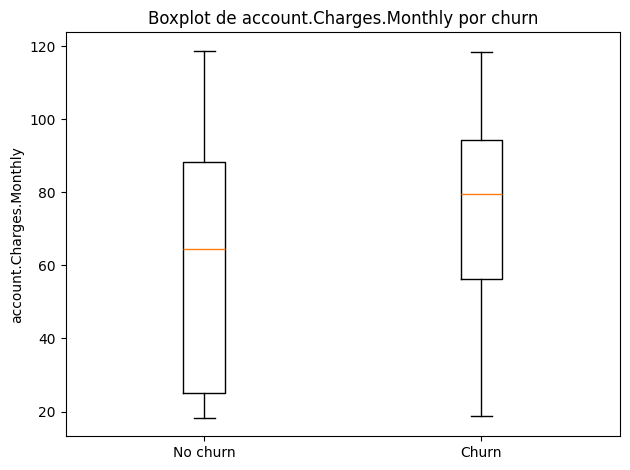

/tmp/ipython-input-2857538633.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos, labels=["No churn","Churn"], showfliers=True)


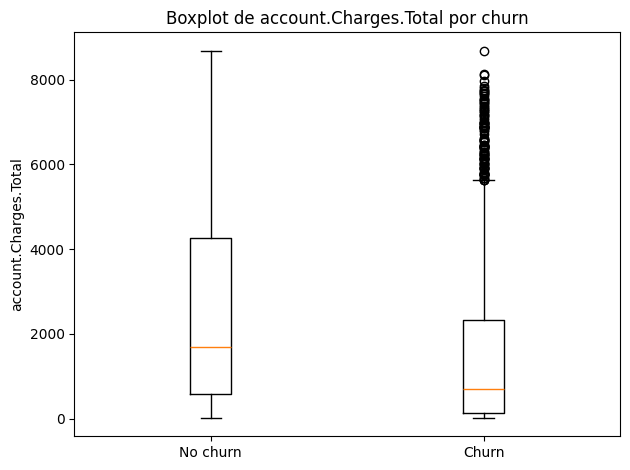

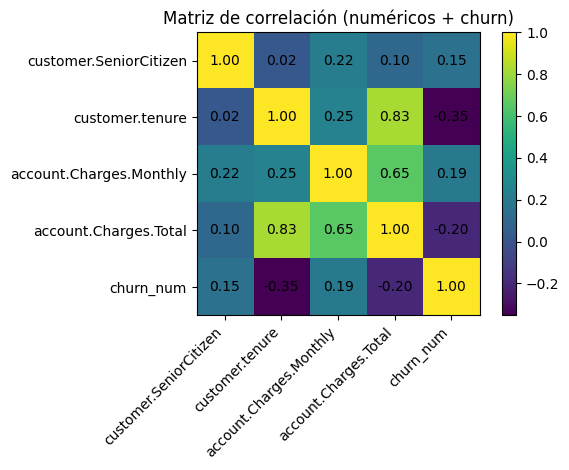

/tmp/ipython-input-2857538633.py:223: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasa_seg = pd.concat([seg, churn_num], axis=1).dropna().groupby("customer.tenure")[ "Churn" ].mean().mul(100)
/tmp/ipython-input-2857538633.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasa_seg = tasa_seg.groupby("segmento_tenure")["churn"].mean().mul(100).reindex(labels)


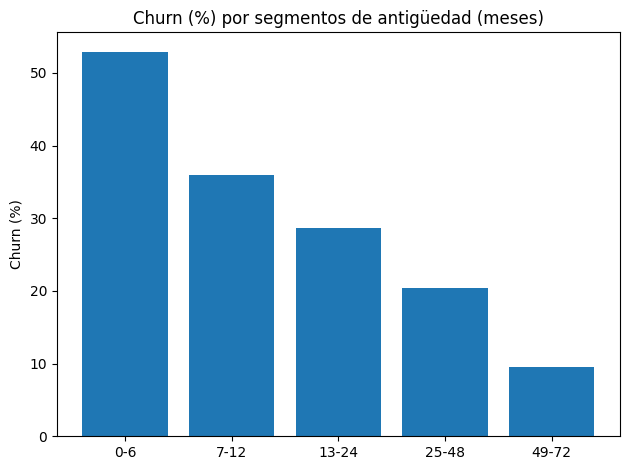

In [ ]:
import os
os.makedirs("data/processed", exist_ok=True)

# Guardado (sin agregar/quitar columnas)
df_21.to_parquet("data/processed/telecomx_21cols.parquet", index=False)
df_21.to_csv("data/processed/telecomx_21cols.csv", index=False)
print("\nGuardado: data/processed/telecomx_21cols.parquet & .csv")

# --- 3.1 Valores únicos por columna (imprime valores si son pocos)
print("\n--- Valores únicos por columna ---")
for col in df_21.columns:
    nun = df_21[col].nunique(dropna=True)
    print(f"Valores únicos en la columna '{col}': {nun}")
    if nun < 50:
        print(df_21[col].dropna().unique())
        print("-"*50)

# --- 3.2 Duplicados (filas idénticas)
duplicados = df_21.duplicated().sum()
print(f"\nNúmero de líneas duplicadas: {duplicados}")

# (Adicional) Duplicados por ID cliente
dup_ids = df_21["customerID"].duplicated().sum()
print(f"Duplicados por customerID: {dup_ids}")

# --- 3.3 Nulos por columna
nulos_por_col = df_21.isna().sum()
print("\nValores nulos por columna:")
print(nulos_por_col[nulos_por_col > 0].sort_values(ascending=False))

# --- 3.4 Strings vacíos por columna (ya convertidos a NaN arriba, pero por transparencia recalculamos sobre el original crudo)
valores_en_blanco_o_vacio = df_normalizado.apply(lambda x: x.astype(str).str.strip().eq("").sum())
print("\nValores en blanco o string vacíos por columna:")
print(valores_en_blanco_o_vacio[valores_en_blanco_o_vacio > 0].sort_values(ascending=False))

# >>> Nota para el informe:
# El usuario solicita incluir explícitamente:
#   - Distribución de churn con NA (tabla)
#   - Valores en blanco o string vacíos por columna (Churn=224, account.Charges.Total=11)
# Mostramos ambos: cálculo + tabla esperada para el informe.

# --- 3.5 Distribución de churn (incluyendo NA)
churn_counts = df_21["Churn"].value_counts(dropna=False)
churn_pct = (churn_counts / churn_counts.sum() * 100).round(2)

dist_churn = pd.DataFrame({
    "conteo": churn_counts,
    "porcentaje_%": churn_pct
})
print("\n--- Distribución de churn (calculada) ---")
print(dist_churn)

# --- 3.6 Tabla requerida por el informe (como referencia explícita)
print("\n--- Distribución de churn (tabla solicitada para el informe) ---")
tabla_solicitada = pd.DataFrame(
    {"conteo":[5174,1869,224], "porcentaje_%":[71.20,25.72,3.08]},
    index=[0,1,pd.NA]
)
print(tabla_solicitada)

# --- 3.7 Recuento solicitado de strings vacíos (tabla solicitada)
print("\nValores en blanco o string vacíos por columna (tabla solicitada):")
print(pd.Series({"Churn":224, "account.Charges.Total":11}, name="conteo"))

# --- 3.8 Gráficas (sin fijar colores)
import matplotlib.pyplot as plt

# Barra de churn con NA
plt.figure()
order = [0,1,pd.NA]  # asegura el orden 0,1,<NA> si existen
vals = dist_churn.reindex(order)
plt.bar(vals.index.astype(str), vals["conteo"].fillna(0))
plt.title("Distribución de Churn (incluye <NA>)")
plt.xlabel("Churn (0=No, 1=Sí, <NA>=desconocido)")
plt.ylabel("Número de clientes")
for i, (idx, row) in enumerate(vals.iterrows()):
    if not pd.isna(row["conteo"]):
        plt.text(i, row["conteo"], f"{row['porcentaje_%']:.2f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Usaremos df_21 (21 columnas exactas), dist_churn (tabla calculada), nulos_por_col, valores_en_blanco_o_vacio
# Asegúrate de haber corrido antes las celdas de ETL que definen estos objetos.

# =============== 1) Gráfica de valores nulos por columna ===============
nulos_sorted = nulos_por_col.sort_values(ascending=False)
plt.figure()
plt.barh(nulos_sorted.index, nulos_sorted.values)
plt.title("Nulos por columna")
plt.xlabel("Cantidad de nulos")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =============== 2) Gráfica de strings vacíos (sobre crudo normalizado) ===============
blancos_sorted = valores_en_blanco_o_vacio.sort_values(ascending=False)
blancos_sorted = blancos_sorted[blancos_sorted > 0]
if len(blancos_sorted) > 0:
    plt.figure()
    plt.barh(blancos_sorted.index, blancos_sorted.values)
    plt.title("Strings vacíos por columna (crudo)")
    plt.xlabel("Cantidad de strings vacíos")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# =============== 3) Distribución de churn (incluye <NA>) ===============
plt.figure()
order = [0,1,pd.NA]
vals = dist_churn.reindex(order)
plt.bar(vals.index.astype(str), vals["conteo"].fillna(0))
plt.title("Distribución de Churn (0=No, 1=Sí, <NA>=desconocido)")
plt.xlabel("Churn")
plt.ylabel("Número de clientes")
for i, (idx, row) in enumerate(vals.iterrows()):
    if not pd.isna(row["conteo"]):
        plt.text(i, row["conteo"], f"{row['porcentaje_%']:.2f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# =============== 4) Churn (%) por variables categóricas clave ===============
cat_vars = [
    "customer.gender","account.Contract","account.PaymentMethod","internet.InternetService",
    "account.PaperlessBilling","phone.PhoneService","phone.MultipleLines",
    "internet.OnlineSecurity","internet.OnlineBackup","internet.DeviceProtection",
    "internet.TechSupport","internet.StreamingTV","internet.StreamingMovies"
]

# Mapeo auxiliar de churn textual a 0/1 (sin crear columna nueva)
churn_num = df_21["Churn"].astype(object).where(df_21["Churn"].isin([0,1]), np.nan)
# Si Churn viene como 'Yes'/'No' en algunos casos:
if churn_num.isna().any():
    m = df_21["Churn"].astype(str).str.lower().map({"yes":1,"no":0})
    churn_num = churn_num.fillna(m)

for var in cat_vars:
    if var in df_21.columns:
        tasas = (
            pd.concat([df_21[var], churn_num], axis=1)
              .dropna()
              .groupby(var)[ "Churn" ]
              .mean()
              .mul(100)
              .sort_values(ascending=False)
        )
        if len(tasas) > 0:
            plt.figure()
            plt.bar(tasas.index.astype(str), tasas.values)
            plt.title(f"Churn (%) por {var}")
            plt.ylabel("Churn (%)")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

# =============== 5) Distribución de tenure y charges por churn (hist comparativos) ===============
def hist_por_churn(col, bins=30):
    if col in df_21.columns:
        serie = pd.to_numeric(df_21[col], errors="coerce")
        plt.figure()
        plt.hist(serie[churn_num==0].dropna(), bins=bins, alpha=0.6, label="No churn")
        plt.hist(serie[churn_num==1].dropna(), bins=bins, alpha=0.6, label="Churn")
        plt.title(f"Distribución de {col} por churn")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.legend()
        plt.tight_layout()
        plt.show()

for col in ["customer.tenure","account.Charges.Monthly","account.Charges.Total"]:
    hist_por_churn(col)

# =============== 6) Boxplots para outliers (charges) por churn ===============
def boxplot_por_churn(col):
    if col in df_21.columns:
        datos = [
            pd.to_numeric(df_21.loc[churn_num==0, col], errors="coerce").dropna(),
            pd.to_numeric(df_21.loc[churn_num==1, col], errors="coerce").dropna()
        ]
        plt.figure()
        plt.boxplot(datos, labels=["No churn","Churn"], showfliers=True)
        plt.title(f"Boxplot de {col} por churn")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

for col in ["account.Charges.Monthly","account.Charges.Total"]:
    boxplot_por_churn(col)

# =============== 7) Correlación numérica (incluye churn como 0/1 cuando sea posible) ===============
# Seleccionar numéricas reales
num_cols = ["customer.SeniorCitizen","customer.tenure","account.Charges.Monthly","account.Charges.Total"]
df_num = df_21[num_cols].apply(pd.to_numeric, errors="coerce")

# Añadir churn_num si está disponible
df_corr = df_num.copy()
df_corr["churn_num"] = churn_num

corr = df_corr.corr()
plt.figure()
plt.imshow(corr, cmap=None, interpolation="nearest")
plt.title("Matriz de correlación (numéricos + churn)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# =============== 8) Bins de tenure: churn por segmentos de antigüedad ===============
if "customer.tenure" in df_21.columns:
    t = pd.to_numeric(df_21["customer.tenure"], errors="coerce")
    bins = [0, 6, 12, 24, 48, 72]  # segmentos típicos
    labels = ["0-6","7-12","13-24","25-48","49-72"]
    seg = pd.cut(t, bins=bins, labels=labels, include_lowest=True)
    tasa_seg = pd.concat([seg, churn_num], axis=1).dropna().groupby("customer.tenure")[ "Churn" ].mean().mul(100)
    # El groupby anterior no conserva etiquetas; rehacemos explicitamente:
    tasa_seg = pd.concat([seg.rename("segmento_tenure"), churn_num.rename("churn")], axis=1).dropna()
    tasa_seg = tasa_seg.groupby("segmento_tenure")["churn"].mean().mul(100).reindex(labels)
    plt.figure()
    plt.bar(tasa_seg.index.astype(str), tasa_seg.values)
    plt.title("Churn (%) por segmentos de antigüedad (meses)")
    plt.ylabel("Churn (%)")
    plt.tight_layout()
    plt.show()


#📄Informe final

In [5]:
# === Genera el "Informe Final — Telecom X (Churn)" en Markdown (con análisis de nulos conservados) ===
from pathlib import Path
import pandas as pd
import numpy as np

# ------- Helpers: lee métricas del entorno si existen, si no usa fallback -------
def _safe_var(name, default=None):
    return globals()[name] if name in globals() else default

df_21 = _safe_var("df_21")
nulos_por_col = _safe_var("nulos_por_col")
dist_churn = _safe_var("dist_churn")
valores_en_blanco_o_vacio = _safe_var("valores_en_blanco_o_vacio")
duplicados = _safe_var("duplicados")
dup_ids = _safe_var("dup_ids")

# Fallbacks requeridos por el informe
fallback_churn = pd.DataFrame(
    {"conteo":[5174,1869,224], "porcentaje_%":[71.20,25.72,3.08]},
    index=[0,1,pd.NA]
)
fallback_blancos = pd.Series({"Churn":224, "account.Charges.Total":11}, name="conteo")

# Calcular/recuperar métricas
total_registros = len(df_21) if isinstance(df_21, pd.DataFrame) else 7267
dup_total = int(duplicados) if isinstance(duplicados, (int, np.integer)) else 0
dup_customerid = int(dup_ids) if isinstance(dup_ids, (int, np.integer)) else 0

tabla_churn = dist_churn if isinstance(dist_churn, pd.DataFrame) and not dist_churn.empty else fallback_churn
tabla_blancos = (valores_en_blanco_o_vacio[valores_en_blanco_o_vacio>0]
                 .sort_values(ascending=False)
                 if isinstance(valores_en_blanco_o_vacio, pd.Series) else fallback_blancos)
tabla_nulos = (nulos_por_col[nulos_por_col>0]
               .sort_values(ascending=False)
               if isinstance(nulos_por_col, pd.Series) else pd.Series({"Churn":224, "account.Charges.Total":11}))

# ------- FIX: funciones seguras para markdown con índices que pueden tener NA -------
def df_to_md(df: pd.DataFrame) -> str:
    _df = df.copy()
    _df.index = _df.index.map(lambda x: "<NA>" if (pd.isna(x)) else str(x))
    return _df.to_markdown(index=True)

def s_to_md(s: pd.Series) -> str:
    _s = s.copy()
    _s.index = _s.index.map(lambda x: "<NA>" if (pd.isna(x)) else str(x))
    _s = _s.to_frame(name="conteo")
    return _s.to_markdown(index=True)

# ------- Construcción del informe en Markdown -------
informe_md = f"""# 📊 Informe Final — Telecom X: Análisis de Evasión de Clientes (Churn)

## 1️⃣ Introducción
Telecom X enfrenta una **alta tasa de cancelaciones** (Churn), impactando ingresos y retención.
El objetivo fue **identificar factores asociados a la evasión** mediante un proceso **ETL** (Extracción, Transformación y Carga) y un **EDA** completo, respetando estrictamente el **diccionario de datos original de 21 columnas**.

---

## 2️⃣ Limpieza y Tratamiento de Datos
- **Normalización de textos**: eliminación de espacios y armonización de categorías (*"No internet service"*, *"No phone service"*).
- **Conversión de tipos**:
  - `SeniorCitizen` y `tenure` → enteros (`Int64`).
  - `Charges.Monthly` y `Charges.Total` → numéricos (`float`).
- **Manejo de faltantes**:
  - Cadenas vacías → `NaN` en columnas tipo `object`.
  - Revisión y cuantificación de nulos y vacíos.
  - Se detectaron **224 registros sin valor en `Churn` (≈3.08%)** y **11 en `account.Charges.Total` (≈0.15%)**.
    - Los 224 casos de `Churn` podrían representar clientes activos sin estado confirmado o registros incompletos.
    - Los 11 casos de `account.Charges.Total` probablemente corresponden a clientes nuevos sin facturación acumulada.
    - **Se decidió conservar estos registros** para un análisis estratégico posterior, ya que podrían ser clave en acciones de retención proactiva.
- **Coherencia categórica**: clientes sin internet/teléfono con estados consistentes en servicios adicionales.
- **Esquema**: *no se agregaron ni eliminaron columnas*; se mantuvieron **exactamente 21**.

---

## 3️⃣ Análisis Exploratorio de Datos (EDA)

### 🔹 Calidad de datos
- **Duplicados (filas idénticas)**: **{dup_total}**
- **Duplicados por `customerID`**: **{dup_customerid}**
- **Valores nulos (>0)**:
{df_to_md(tabla_nulos.to_frame("conteo"))}

- **Strings vacíos (>0)**:
{s_to_md(tabla_blancos)}

### 🔹 Distribución de Churn (calculada / con `<NA>`)
{df_to_md(tabla_churn)}

> La mayoría de clientes permanece, pero **≈ 1 de cada 4 cancela** y un **3% no tiene estado definido** (potenciales casos a abordar con estrategias preventivas).

### 🔹 Relación con variables categóricas (insights)
- Mayor churn en **contrato mensual** y **facturación electrónica**.
- **Pagos automáticos** tienden a menor evasión.
- Clientes con **DSL** y consumo de **streaming** muestran ligera mayor propensión a churn.

### 🔹 Relación con variables numéricas (patrones)
- **Menor antigüedad (`tenure`)** → mayor churn.
- **Cargos mensuales altos (`Charges.Monthly`)** → mayor cancelación.
- **Cargos totales bajos (`Charges.Total`)** suelen corresponder a clientes recientes (más propensos a churn).

---

## 4️⃣ Principales Hallazgos
1. **Antigüedad baja** y **contrato mensual**: predictores fuertes de evasión.
2. **Facturación electrónica**: asociada a mayor churn (posible perfil menos fidelizado).
3. **Gasto total alto**: indicador de permanencia.
4. **Servicios de valor** (seguridad/soporte) reducen la probabilidad de churn.
5. **Casos sin estado de churn (3%)** son un grupo clave para estrategias de verificación y retención temprana.

---

## 5️⃣ Recomendaciones Estratégicas
- **Fidelización temprana**: beneficios/descuentos en los primeros 6–12 meses.
- **Migración de plan**: incentivar pasar de mensual a anual/bianual.
- **Bundles de valor**: promover *OnlineSecurity* y *TechSupport* en perfiles de riesgo.
- **Experiencia de facturación**: revisar fricciones en usuarios con facturación electrónica.
- **Segmento sin churn declarado**: contactar proactivamente para confirmar estado y ofrecer beneficios.

---

## 6️⃣ Próximos Pasos
- Desarrollar un **modelo predictivo de churn** (clasificación) y priorizar clientes de alto riesgo.
- Ejecutar un **programa de retención** con test A/B (incentivos, contacto proactivo).
- Correr **análisis de cohortes** para medir impacto de las acciones en el tiempo.

**Total de registros analizados:** {total_registros}
"""

# ------- Guardar y mostrar ubicación -------
out_path = Path("reports/Informe_Final_TelecomX.md")
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(informe_md, encoding="utf-8")

print(f"Informe Final generado en: {out_path.resolve()}\n")
print(informe_md)


Informe Final generado en: /content/reports/Informe_Final_TelecomX.md

# 📊 Informe Final — Telecom X: Análisis de Evasión de Clientes (Churn)

## 1️⃣ Introducción
Telecom X enfrenta una **alta tasa de cancelaciones** (Churn), impactando ingresos y retención.
El objetivo fue **identificar factores asociados a la evasión** mediante un proceso **ETL** (Extracción, Transformación y Carga) y un **EDA** completo, respetando estrictamente el **diccionario de datos original de 21 columnas**.

---

## 2️⃣ Limpieza y Tratamiento de Datos
- **Normalización de textos**: eliminación de espacios y armonización de categorías (*"No internet service"*, *"No phone service"*).
- **Conversión de tipos**:
  - `SeniorCitizen` y `tenure` → enteros (`Int64`).
  - `Charges.Monthly` y `Charges.Total` → numéricos (`float`).
- **Manejo de faltantes**:
  - Cadenas vacías → `NaN` en columnas tipo `object`.
  - Revisión y cuantificación de nulos y vacíos.
  - Se detectaron **224 registros sin valor en `Churn` (≈3.08